# Librerias y carga de datos

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Metricas
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    confusion_matrix,
    classification_report
)

# KNN para comparacion
from sklearn.neighbors import KNeighborsClassifier

sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Cargar datos

In [ ]:
# Cargar CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:2000]
y_test = y_test[:2000]

print("Datos cargados")

Datos cargados


# Redimensionar imagenes

In [ ]:
batch_size = 64  # Reducir batch size para evitar errores de memoria en colab
img_size = 64 # Definimos el tamaño de la imagen

# Funcion de preprocesamiento
def preprocess_train(image, label):
    image = tf.image.resize(image, (img_size, img_size))
    # Normalizar
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_test(image, label):
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Crear datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Verificar shapes
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Batch shape: (64, 64, 64, 3)
Labels shape: (64, 1)


# Ver resultados de redimension

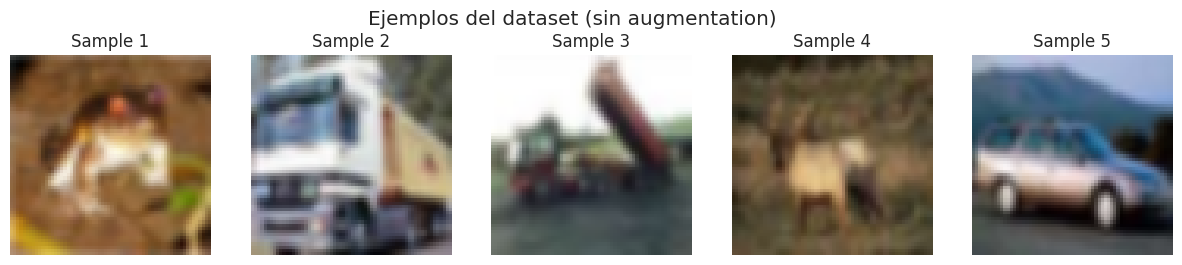

In [ ]:
def visualize_samples(dataset, num_images=5):
    plt.figure(figsize=(15, 3))
    for images, _ in dataset.take(1):
        for i in range(num_images):
            plt.subplot(1, num_images, i+1)
            plt.imshow(images[i].numpy())
            plt.axis('off')
            plt.title(f"Sample {i+1}")
    plt.suptitle("Ejemplos del dataset (sin augmentation)")
    plt.show()

visualize_samples(train_dataset)

# Modelo CNN con tranfer Learning

/tmp/ipython-input-1395190342.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

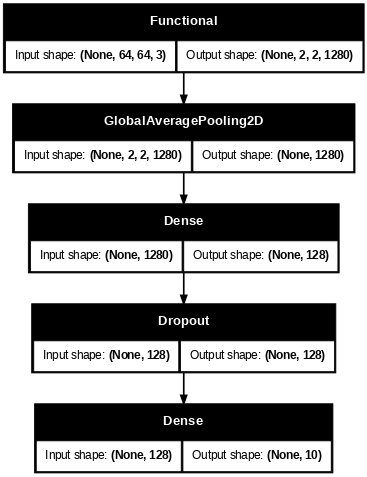

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Congelamos las primeras capas
base_model.trainable = False

model_cnn = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

# Plot de arquitectura
plot_model(model_cnn, show_shapes=True, dpi=60)

# Entrenamiento CNN y evaluacion supervisada

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.3798 - loss: 1.8261 - val_accuracy: 0.5910 - val_loss: 1.1791
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 259ms/step - accuracy: 0.6243 - loss: 1.0837 - val_accuracy: 0.6220 - val_loss: 1.1053
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - accuracy: 0.6957 - loss: 0.8884 - val_accuracy: 0.6180 - val_loss: 1.0969
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 229ms/step - accuracy: 0.7451 - loss: 0.7485 - val_accuracy: 0.6150 - val_loss: 1.1115
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step - accuracy: 0.7777 - loss: 0.6593 - val_accuracy: 0.6070 - val_loss: 1.1393
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step

Classification Report CNN:
              precision    recall  f1-score   support

       avión       0.62      0.57      0.59       196
        auto       0.64      0.75      0.69       198
      pájaro       0.51      0.48      0.49       195
        gato       0.48      0.50      0.49       199
      vena

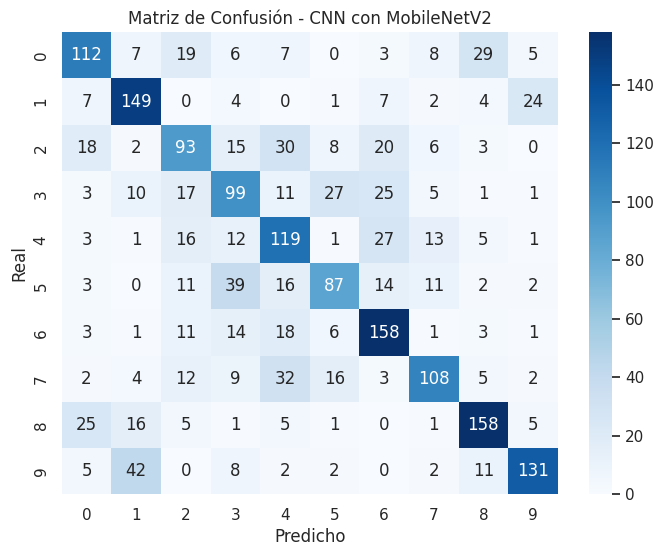

In [ ]:
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model_cnn.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    verbose=1
)

# Recolectar etiquetas reales
y_test_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Prediccion
y_pred_probs = model_cnn.predict(test_dataset.map(lambda x, y: x))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report y Confusion Matrix
print("\nClassification Report CNN:")
print(classification_report(y_test_true, y_pred_classes,
      target_names=['avión', 'auto', 'pájaro', 'gato', 'venado',
                    'perro', 'rana', 'caballo', 'barco', 'camión']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - CNN con MobileNetV2')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# MLP baseline y plot de arquitectura


In [ ]:
# Aplanamos imagenes para MLP
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat  = x_test.reshape(x_test.shape[0], -1)

# Verificar formas
print(f"x_train_flat shape: {x_train_flat.shape}")
print(f"x_test_flat shape: {x_test_flat.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

model_mlp = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(3072,)),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model_mlp.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Plot arquitectura MLP
plot_model(model_mlp, show_shapes=True, dpi=60)

# Entrenamiento
history_mlp = model_mlp.fit(x_train_flat, y_train,
                            epochs=5, batch_size=128,
                            validation_data=(x_test_flat, y_test),
                            verbose=1)

# Evaluacion
score_mlp = model_mlp.evaluate(x_test_flat, y_test, verbose=0)
print(f"Test Accuracy MLP: {score_mlp[1]:.4f}")

x_train_flat shape: (10000, 3072)
x_test_flat shape: (2000, 3072)
y_train shape: (10000, 1)
y_test shape: (2000, 1)
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.1189 - loss: 203.2322 - val_accuracy: 0.1085 - val_loss: 2.3029
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1027 - loss: 2.3044 - val_accuracy: 0.1080 - val_loss: 2.3029
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1040 - loss: 2.3035 - val_accuracy: 0.1080 - val_loss: 2.3027
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1028 - loss: 2.3018 - val_accuracy: 0.1080 - val_loss: 2.3027
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1068 - loss: 2.3020 - val_accuracy: 0.0980 - val_loss: 2.3022
Test Accuracy MLP: 0.0980


# Obtener capas del modelo

In [ ]:
print("Capas del modelo:")
for i, layer in enumerate(model_cnn.layers):
    print(f"{i}: {layer.name}")

Capas del modelo:
0: mobilenetv2_1.00_224
1: global_average_pooling2d_20
2: dense_57
3: dropout_33
4: dense_58


# Extraccion de features de CNN

In [ ]:
input_layer = model_cnn.layers[0].input

# Obtener la capa de features
x = model_cnn.layers[0].output  # Salida de MobileNetV2
x = model_cnn.layers[1](x)      # GlobalAveragePooling2D
x = model_cnn.layers[2](x)      # features_dense

# Extraer la capa dense
feature_extractor = Model(
    inputs=input_layer,
    outputs=x
)

# Extractor
print(f"Input shape: {feature_extractor.input_shape}")
print(f"Output shape: {feature_extractor.output_shape}")

# Extraer features de entrenamiento
features_train = feature_extractor.predict(
    train_dataset.map(lambda x, y: x),
    verbose=1,
    batch_size=128
)

# Extraer features de test
features_test = feature_extractor.predict(
    test_dataset.map(lambda x, y: x),
    verbose=1,
    batch_size=128
)

# Verificamos dimensiones
print(f"\nFeatures train shape: {features_train.shape}")  # (50000, 256)
print(f"Features test shape: {features_test.shape}")      # (10000, 256)

# Etiquetas obtenidas
print(f"Etiquetas train: {y_train.shape}")
print(f"Etiquetas test: {y_test.shape}")

Input shape: (None, 64, 64, 3)
Output shape: (None, 128)
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step

Features train shape: (10000, 128)
Features test shape: (2000, 128)
Etiquetas train: (10000, 1)
Etiquetas test: (2000, 1)


# Reduccion de dimensionalidad y visualizacion

Features test shape: (2000, 128)
Varianza explicada: 0.761
Features PCA shape: (2000, 30)


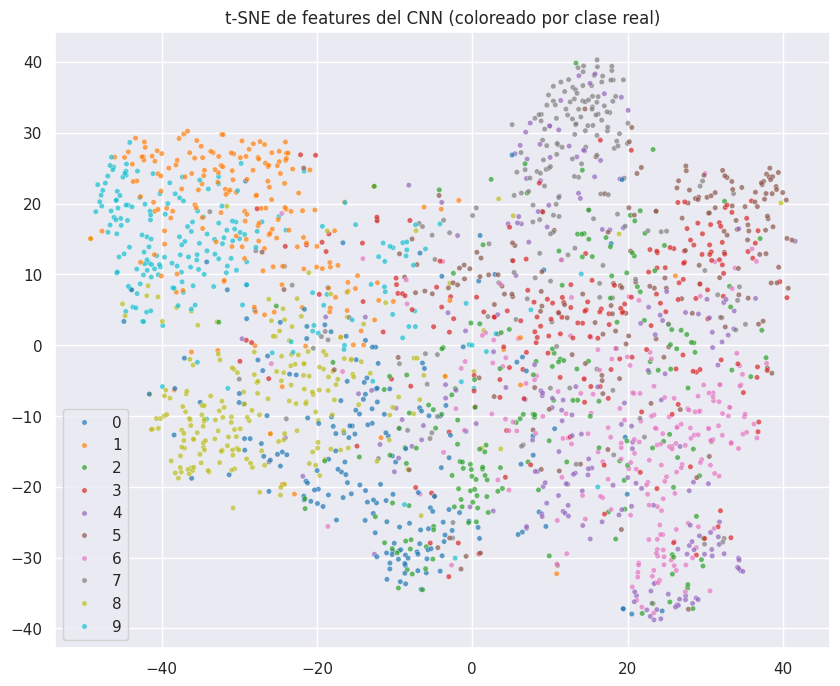

In [ ]:
print("Features test shape:", features_test.shape)

# PCA
pca = PCA(n_components=30, random_state=42)
features_pca = pca.fit_transform(features_test)
print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.3f}")
print(f"Features PCA shape: {features_pca.shape}")

# t-SNE para visualizacion
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

# Visualizacion t-SNE por clase real
plt.figure(figsize=(10,8))
sns.scatterplot(x=features_tsne[:,0], y=features_tsne[:,1],
                hue=y_test.flatten(), palette="tab10", s=15, alpha=0.7)
plt.title("t-SNE de features del CNN (coloreado por clase real)")
plt.show()

# Clustering en espacio latente

K-Means  -> Silhouette: 0.097431034
K-Means  -> ARI: 0.19142917137518686
GMM      -> Silhouette: 0.050716013
GMM      -> ARI: 0.18263653030299093


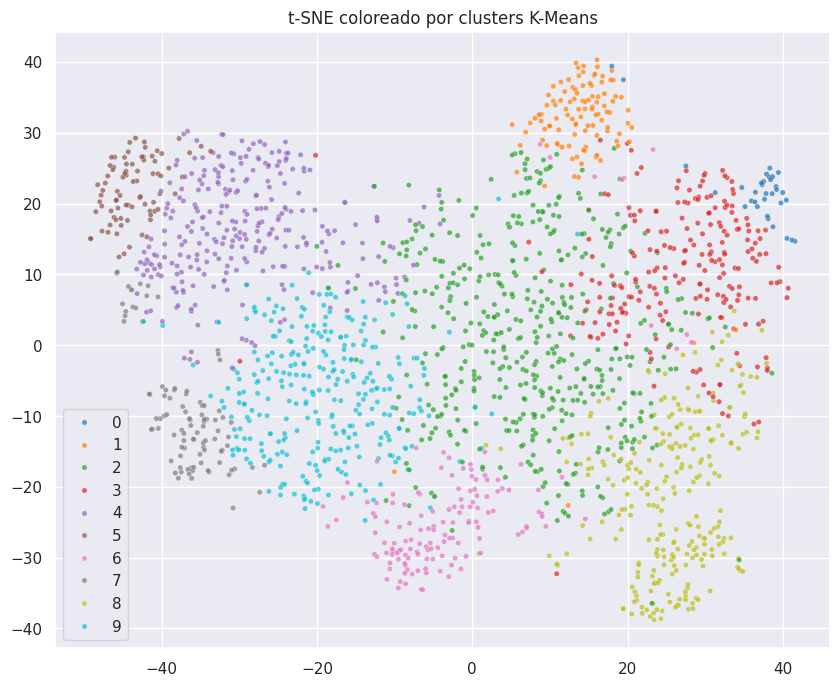

In [ ]:
# K-Means
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(features_pca)

# GMM
gmm = GaussianMixture(n_components=10, random_state=42)
labels_gmm = gmm.fit_predict(features_pca)

# Métricas
print("K-Means  -> Silhouette:", silhouette_score(features_pca, labels_kmeans))
print("K-Means  -> ARI:", adjusted_rand_score(y_test_true.flatten(), labels_kmeans))

print("GMM      -> Silhouette:", silhouette_score(features_pca, labels_gmm))
print("GMM      -> ARI:", adjusted_rand_score(y_test_true.flatten(), labels_gmm))

# Visualización clusters
plt.figure(figsize=(10,8))
sns.scatterplot(x=features_tsne[:,0], y=features_tsne[:,1],
                hue=labels_kmeans, palette="tab10", s=15, alpha=0.7)
plt.title("t-SNE coloreado por clusters K-Means")
plt.show()

# Comparaciones y conclusiones

In [ ]:
# Evaluar CNN
cnn_loss, cnn_acc = model_cnn.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy CNN: {cnn_acc:.4f}")

# KNN sobre features del CNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(features_train, y_train.flatten())
acc_knn = knn.score(features_test, y_test.flatten())

print(f"Accuracy KNN sobre features CNN: {acc_knn:.4f}")

# Tabla resumen
resultados = {
    "Modelo": ["CNN (Transfer Learning)", "MLP Baseline", "KNN (sobre features)"],
    "Accuracy": [cnn_acc, score_mlp[1], acc_knn]
}

import pandas as pd
df_res = pd.DataFrame(resultados)
print("\n=== RESULTADOS FINALES ===")
print(df_res)

Test Accuracy CNN: 0.6070
Accuracy KNN sobre features CNN: 0.5910

=== RESULTADOS FINALES ===
                    Modelo  Accuracy
0  CNN (Transfer Learning)     0.607
1             MLP Baseline     0.098
2     KNN (sobre features)     0.591
